## Ace Attorney Ablation Study

In [8]:
import sys, pathlib; sys.path.append(str(pathlib.Path().resolve().parent))
import os
import numpy as np
import pandas as pd
from scipy.stats import spearmanr
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
import requests
import json

from tools.serving.api_providers import (
    openai_text_reasoning_completion,
    anthropic_text_completion,
    gemini_text_completion,
    together_ai_completion,
    xai_grok_completion
)

In [16]:
# Create a prompt template with {level name} as the placeholder
prompt_template = """
You are an expert on *Phoenix Wright: Ace Attorney*.

LEVEL = “{level name}”

Return **exactly** the two sections below, in the order shown, with *nothing* else before or after them.

1) Complete Evidence List:
- "Exact In-Game Item Name" (Type) Relevance: one-sentence explanation of why it helps the defense.
- (repeat bullet for every distinct item)

2) Cross-Examination Breakdown:
- **<Witness Name>, Round X**
  - Statement: <key line from testimony>
  - Present: <evidence name>  (or “Press” if simply pressing)
  - Contradiction Exposed: <logical inconsistency uncovered>
  - Impact: <how this advances Phoenix’s case>
- (add bullets for every round / witness)

**Formatting rules (must follow strictly):**
- Use the section headings *exactly* as written (including numbers, parentheses, and colons).
- Leave exactly one blank line between sections.
- Sections 1 & 2 must be bullet lists that match the patterns shown.
- Do **not** add extra commentary, headings, or markdown.
- If a detail is unknown in-game, omit it rather than inventing filler.
"""

# Define the level names
level_names = ["The First Turnabout", "Turnabout Sisters - (Part 1 to Part 4)"]

# Create the actual prompts
prompts = [prompt_template.format(**{"level name": level_name}) for level_name in level_names]

# Step 1: Define prompts and load performance data
def setup_study_data():
    # Load the performance data
    with open("./rank_data_03_25_2025.json", "r") as f:
        performance_data = json.load(f)
    
    # Extract Ace Attorney ranks
    ace_attorney_data = performance_data["Ace Attorney"]["results"]
    
    # Create a dictionary mapping model names to ranks and scores
    model_performance = {}
    for result in ace_attorney_data:
        model_name = result["model"]
        model_performance[model_name] = {
            "rank": result["rank"],
            "levels_cracked": result["levels_cracked"],
            "score": result["score"]
        }
    
    # Load ground truth transcripts
    with open("./ace_attorney_ground_truth.json", "r") as f:
        ground_truth = json.load(f)
    
    # Extract transcripts in the same order as level_names
    transcripts = [ground_truth[level_name] for level_name in level_names]
    
    return prompts, level_names, model_performance, transcripts

# Step 2: Generate Text Descriptions
def generate_descriptions(models, prompts, level_names):
    # First try to load existing results
    try:
        with open("generated_texts.json", "r") as f:
            results = json.load(f)
    except (FileNotFoundError, json.JSONDecodeError):
        results = {}
    
    for model_name in models:
        # Skip if model results already exist
        if model_name in results:
            print(f"Skipping {model_name} - already exists in results")
            continue
            
        results[model_name] = {}
        
        for prompt, level_name in zip(prompts, level_names):
            system_prompt = "You are an Ace Attorney expert."
            print(f"Generating for {model_name} - {level_name}")
            
            try:
                # Generate based on model provider
                if "o1-" in model_name or "o3-" in model_name or "o4-" in model_name or "gpt-" in model_name:
                    generated_text = openai_text_reasoning_completion(
                        system_prompt=system_prompt,
                        model_name=model_name,
                        prompt=prompt,
                        temperature=0
                    )

                elif "claude-3-7-sonnet-20250219(thinking)" in model_name:
                    generated_text = anthropic_text_completion(
                        system_prompt=system_prompt,
                        model_name="claude-3-7-sonnet-20250219",
                        prompt=prompt,
                        thinking=True
                    )
                    
                elif "claude" in model_name:
                    generated_text = anthropic_text_completion(
                        system_prompt=system_prompt,
                        model_name=model_name,
                        prompt=prompt,
                        thinking=False
                    )
                    
                elif "gemini" in model_name:
                    generated_text = gemini_text_completion(
                        system_prompt=system_prompt,
                        model_name=model_name,
                        prompt=prompt
                    )
                    
                elif "llama-4-maverick" in model_name.lower():
                    generated_text = together_ai_completion(
                        system_prompt=system_prompt,
                        model_name=model_name,
                        prompt=prompt,
                        temperature=0
                    )
                elif "grok-3" in model_name:
                    generated_text = xai_grok_completion(
                        system_prompt=system_prompt,
                        model_name=model_name,
                        prompt=prompt,
                        temperature=0
                    )
                
                results[model_name][level_name] = generated_text
                
                # Save after each successful generation
                with open("generated_texts.json", "w") as f:
                    json.dump(results, f, indent=4)
                    
            except Exception as e:
                print(f"Error generating for {model_name} - {level_name}: {str(e)}")
                # Save partial results even if there's an error
                with open("generated_texts.json", "w") as f:
                    json.dump(results, f, indent=4)
                continue
            
    return results

def compute_similarity(generated_texts, transcripts):
    # Load SBERT model
    model = SentenceTransformer("all-MiniLM-L6-v2")
    
    similarity_scores = {}
    
    for model_name, texts in generated_texts.items():
        similarity_scores[model_name] = []
        
        # Debug print
        print(f"Processing model: {model_name}")
        print(f"Available texts: {list(texts.keys())}")
        
        try:
            for i, level_name in enumerate(level_names):
                if level_name in texts:
                    # Get embeddings
                    emb_gen = model.encode(texts[level_name], show_progress_bar=False)
                    emb_trans = model.encode(transcripts[i], show_progress_bar=False)
                    
                    # Calculate cosine similarity
                    sim_score = cosine_similarity([emb_gen], [emb_trans])[0][0]
                    similarity_scores[model_name].append(sim_score)
                    
                    print(f"Computed similarity for {level_name}: {sim_score:.4f}")
                else:
                    print(f"Warning: Missing text for {level_name} in {model_name}")
                    similarity_scores[model_name].append(0.0)  # or np.nan if you prefer
                
        except KeyError as e:
            print(f"Error processing {model_name}: Missing key {e}")
            print(f"Available keys: {list(texts.keys())}")
            continue
        except Exception as e:
            print(f"Error processing {model_name}: {str(e)}")
            continue
    
    return similarity_scores

# Step 4: Calculate total similarity and correlation with performance
def analyze_correlation(similarity_scores, model_performance):
    # Calculate total similarity score for each model
    total_similarity = {}
    for model_name, scores in similarity_scores.items():
        total_similarity[model_name] = sum(scores)
    
    # Prepare data for correlation
    models = []
    sim_scores = []
    ranks = []
    game_scores = []
    
    for model_name, total_sim in total_similarity.items():
        if model_name in model_performance:
            models.append(model_name)
            sim_scores.append(total_sim)
            ranks.append(model_performance[model_name]["rank"])
            game_scores.append(model_performance[model_name]["score"])
    
    # Calculate Spearman's rank correlation with rank
    rank_rho, rank_p_val = spearmanr(sim_scores, ranks)
    
    # Calculate Spearman's rank correlation with game score
    score_rho, score_p_val = spearmanr(sim_scores, game_scores)
    
    # Create a summary DataFrame
    results_df = pd.DataFrame({
        "Model": models,
        "Total Similarity": sim_scores,
        "Performance Rank": ranks,
        "Game Score": game_scores
    })
    
    # Sort by total similarity
    results_df = results_df.sort_values("Total Similarity", ascending=False)
    
    correlation_results = {
        "rank_correlation": rank_rho,
        "rank_p_value": rank_p_val,
        "score_correlation": score_rho,
        "score_p_value": score_p_val
    }
    
    return results_df, correlation_results, total_similarity

# Step 5: Main Function
def run_ablation_study():
    # Setup data
    prompts, level_names, model_performance, transcripts = setup_study_data()
    
    # Define models to test as specified by the user
    models = [
        "o3-2025-04-16",
        "gemini-2.5-pro-preview-03-25",
        "claude-3-7-sonnet-20250219(thinking)",
        "claude-3-5-sonnet-20241022",
        "o4-mini-2025-04-16",
        "Llama-4-Maverick-17B-128E-Instruct-FP8"
    ]
    
    
    # Generate descriptions
    print("Generating model descriptions...")
    generated_texts = generate_descriptions(models, prompts, level_names)
    
    # Compute similarities
    print("Computing semantic similarities...")
    similarity_scores = compute_similarity(generated_texts, transcripts)
    
    # Analyze correlations
    print("Analyzing correlations...")
    results_df, correlation_results, total_similarity = analyze_correlation(similarity_scores, model_performance)
    
    # Display results
    print("\nCorrelation Results:")
    print(f"Correlation with rank: {correlation_results['rank_correlation']:.4f} (p-value = {correlation_results['rank_p_value']:.4f})")
    print(f"Correlation with game score: {correlation_results['score_correlation']:.4f} (p-value = {correlation_results['score_p_value']:.4f})")
    
    # Create a detailed DataFrame showing similarity scores for each prompt
    detailed_df = pd.DataFrame({
        "Model": list(similarity_scores.keys()),
        "First Turnabout Similarity": [scores[0] for scores in similarity_scores.values()],
        "Sister Turnabout Similarity": [scores[1] for scores in similarity_scores.values()],
        "Total Similarity": [total_similarity[model] for model in similarity_scores.keys()]
    })
    
    # Add performance data where available
    performance_rank = []
    performance_score = []
    
    for model in detailed_df["Model"]:
        if model in model_performance:
            performance_rank.append(model_performance[model]["rank"])
            performance_score.append(model_performance[model]["score"])
        else:
            performance_rank.append(np.nan)
            performance_score.append(np.nan)
    
    detailed_df["Performance Rank"] = performance_rank
    detailed_df["Game Score"] = performance_score
    
    # Sort by total similarity
    detailed_df = detailed_df.sort_values("Total Similarity", ascending=False)
    
    return results_df, correlation_results, detailed_df, generated_texts, similarity_scores

# Run the study if executed directly
if __name__ == "__main__":
    results_df, correlation_results, detailed_df, generated_texts, similarity_scores = run_ablation_study()
    print("\nDetailed Results:")
    print(detailed_df)

Generating model descriptions...
Skipping o3-2025-04-16 - already exists in results
Skipping gemini-2.5-pro-preview-03-25 - already exists in results
Skipping claude-3-7-sonnet-20250219(thinking) - already exists in results
Skipping claude-3-5-sonnet-20241022 - already exists in results
Skipping o4-mini-2025-04-16 - already exists in results
Skipping Llama-4-Maverick-17B-128E-Instruct-FP8 - already exists in results
Computing semantic similarities...
Processing model: o3-2025-04-16
Available texts: ['The First Turnabout', 'Turnabout Sisters - (Part 1 to Part 4)']
Computed similarity for The First Turnabout: 0.8630
Computed similarity for Turnabout Sisters - (Part 1 to Part 4): 0.9044
Processing model: gemini-2.5-pro-preview-03-25
Available texts: ['The First Turnabout', 'Turnabout Sisters - (Part 1 to Part 4)']
Computed similarity for The First Turnabout: 0.8667
Computed similarity for Turnabout Sisters - (Part 1 to Part 4): 0.8670
Processing model: claude-3-7-sonnet-20250219(thinking)

In [24]:
detailed_df

,Model,First Turnabout Similarity,Sister Turnabout Similarity,Total Similarity,Performance Rank,Game Score
0,o3-2025-04-16,0.863010,0.904428,1.767438,2,23
1,gemini-2.5-pro-preview-03-25,0.866726,0.866952,1.733678,3,20
3,claude-3-5-sonnet-20241022,0.845162,0.815580,1.660742,6,6
6,o1-2024-12-17,0.808985,0.842305,1.651290,1,26
10,grok-3-mini-beta,0.781703,0.832628,1.614331,5,7
7,gpt-4.1-2025-04-14,0.754770,0.812457,1.567227,7,6
2,claude-3-7-sonnet-20250219(thinking),0.707965,0.830473,1.538438,4,8
9,gemini-2.5-flash-preview-04-17,0.731344,0.728147,1.459491,8,4
8,gemini-2.0-flash-thinking-exp-1219,0.658813,0.779637,1.438450,9,4
5,Llama-4-Maverick-17B-128E-Instruct-FP8,0.490601,0.733536,1.224137,13,0


In [28]:
import json
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

def create_combined_cross_similarity_df(detailed_df):
    # Load ground truth transcripts
    with open("./ace_attorney_ground_truth.json", "r") as f:
        ground_truth = json.load(f)
    level_names = ["The First Turnabout", "Turnabout Sisters - (Part 1 to Part 4)"]
    transcripts = [ground_truth[level_name] for level_name in level_names]

    # Load generated texts
    with open("generated_texts.json", "r") as f:
        generated_texts = json.load(f)

    # Load embedding model
    model = SentenceTransformer("all-MiniLM-L6-v2")

    # Encode ground truth once
    emb_gt_first = model.encode(transcripts[0], show_progress_bar=False)
    emb_gt_sister = model.encode(transcripts[1], show_progress_bar=False)
    gt_to_gt_similarity = cosine_similarity([emb_gt_first], [emb_gt_sister])[0][0]

    # Collect rows
    records = []

    for model_name, levels in generated_texts.items():
        try:
            gen_first = levels["The First Turnabout"]
            gen_sister = levels["Turnabout Sisters - (Part 1 to Part 4)"]

            emb_gen_first = model.encode(gen_first, show_progress_bar=False)
            emb_gen_sister = model.encode(gen_sister, show_progress_bar=False)

            record = {
                "Model": model_name,
                "Gen[First] vs GT[Sister]": cosine_similarity([emb_gen_first], [emb_gt_sister])[0][0],
                "Gen[Sister] vs GT[First]": cosine_similarity([emb_gen_sister], [emb_gt_first])[0][0],
                "Gen[First] vs Gen[Sister]": cosine_similarity([emb_gen_first], [emb_gen_sister])[0][0],
                "Ground Truth": gt_to_gt_similarity,
            }

        except Exception as e:
            print(f"Error processing {model_name}: {str(e)}")
            record = {
                "Model": model_name,
                "Gen[First] vs GT[Sister]": np.nan,
                "Gen[Sister] vs GT[First]": np.nan,
                "Gen[First] vs Gen[Sister]": np.nan,
                "Ground Truth": gt_to_gt_similarity,
            }

        records.append(record)

    cross_df = pd.DataFrame(records)

    # Merge similarity columns from detailed_df
    cross_df = cross_df.merge(
        detailed_df[["Model", "First Turnabout Similarity", "Sister Turnabout Similarity", "Total Similarity"]],
        on="Model",
        how="left"
    )

    # Rename column
    cross_df = cross_df.rename(columns={"Total Similarity": "Generated Total Similarity"})

    # Compute similarity rank (lower rank = better)
    cross_df["Similarity Rank"] = cross_df["Generated Total Similarity"].rank(ascending=False, method="min").astype(int)

    return cross_df


In [29]:
cross_df = create_combined_cross_similarity_df(detailed_df)
cross_df = cross_df.sort_values("Generated Total Similarity", ascending=False).reset_index(drop=True)
cross_df

,Model,Gen[First] vs GT[Sister],Gen[Sister] vs GT[First],Gen[First] vs Gen[Sister],Ground Truth,First Turnabout Similarity,Sister Turnabout Similarity,Generated Total Similarity,Similarity Rank
0,o3-2025-04-16,0.606627,0.593093,0.657062,0.598833,0.863010,0.904428,1.767438,1
1,gemini-2.5-pro-preview-03-25,0.561069,0.544268,0.531750,0.598833,0.866726,0.866952,1.733678,2
2,claude-3-5-sonnet-20241022,0.609118,0.537705,0.671986,0.598833,0.845162,0.815580,1.660742,3
3,o1-2024-12-17,0.634093,0.589231,0.674810,0.598833,0.808985,0.842305,1.651290,4
4,grok-3-mini-beta,0.645571,0.550262,0.707115,0.598833,0.781703,0.832628,1.614331,5
5,gpt-4.1-2025-04-14,0.697489,0.591127,0.787370,0.598833,0.754770,0.812457,1.567227,6
6,claude-3-7-sonnet-20250219(thinking),0.684305,0.535438,0.588225,0.598833,0.707965,0.830473,1.538438,7
7,gemini-2.5-flash-preview-04-17,0.616881,0.537886,0.729042,0.598833,0.731344,0.728147,1.459491,8
8,gemini-2.0-flash-thinking-exp-1219,0.719490,0.561903,0.810311,0.598833,0.658813,0.779637,1.438450,9
9,Llama-4-Maverick-17B-128E-Instruct-FP8,0.593969,0.534625,0.771773,0.598833,0.490601,0.733536,1.224137,10


In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

def plot_global_embedding_correlation(generated_texts, transcripts):
    model = SentenceTransformer("all-MiniLM-L6-v2")

    # Encode GT once
    emb_gt_first = model.encode(transcripts[0], show_progress_bar=False)
    emb_gt_sister = model.encode(transcripts[1], show_progress_bar=False)

    all_embeddings = []
    all_labels = []

    for model_name, levels in generated_texts.items():
        try:
            gen_first = levels["The First Turnabout"]
            gen_sister = levels["Turnabout Sisters - (Part 1 to Part 4)"]

            emb_gen_first = model.encode(gen_first, show_progress_bar=False)
            emb_gen_sister = model.encode(gen_sister, show_progress_bar=False)

            all_embeddings.extend([emb_gen_first, emb_gen_sister])
            all_labels.extend([
                f"{model_name}-Gen[First]",
                f"{model_name}-Gen[Sister]"
            ])
        except Exception as e:
            print(f"Skipping {model_name} due to error: {str(e)}")

    # Add ground truths at the end
    all_embeddings.extend([emb_gt_first, emb_gt_sister])
    all_labels.extend(["GT[First]", "GT[Sister]"])

    # Compute cosine similarity
    sim_matrix = cosine_similarity(all_embeddings)

    # Plot
    plt.figure(figsize=(max(10, 0.35 * len(all_labels)), max(8, 0.35 * len(all_labels))))
    sns.heatmap(sim_matrix, xticklabels=all_labels, yticklabels=all_labels,
                cmap="coolwarm", annot=False, square=True, fmt=".2f", linewidths=0.3)
    plt.title("Global Embedding Correlation (Generated + Ground Truth)")
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    return sim_matrix, all_labels


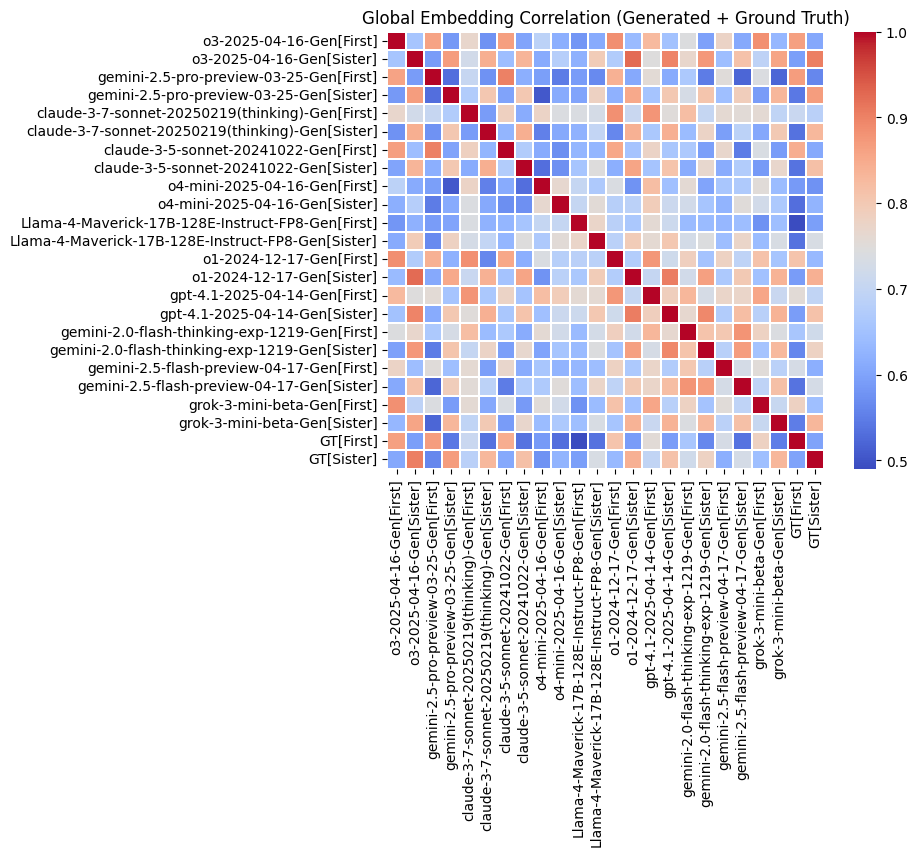

In [45]:
sim_matrix, sim_labels = plot_global_embedding_correlation(generated_texts, transcripts)


In [30]:
detailed_df["Model"]

0                              o3-2025-04-16
1               gemini-2.5-pro-preview-03-25
3                 claude-3-5-sonnet-20241022
6                              o1-2024-12-17
10                          grok-3-mini-beta
7                         gpt-4.1-2025-04-14
2       claude-3-7-sonnet-20250219(thinking)
9             gemini-2.5-flash-preview-04-17
8         gemini-2.0-flash-thinking-exp-1219
5     Llama-4-Maverick-17B-128E-Instruct-FP8
4                         o4-mini-2025-04-16
Name: Model, dtype: object

In [31]:
models_to_keep = [
    "o3-2025-04-16",
    "gemini-2.5-pro-preview-03-25",
    "claude-3-7-sonnet-20250219(thinking)",
    "claude-3-5-sonnet-20241022",
    "o4-mini-2025-04-16",
    "Llama-4-Maverick-17B-128E-Instruct-FP8"
    # "o1-2024-12-17",
    # "grok-3-mini-beta",
    # "gemini-2.5-flash-preview-04-17",
    # "gemini-2.0-flash-thinking-exp-1219",
    # "gpt-4.1-2025-04-14"
]

detailed_df = detailed_df[detailed_df["Model"].isin(models_to_keep)].copy()


In [7]:
detailed_df

,Model,First Turnabout Similarity,Sister Turnabout Similarity,Total Similarity,Performance Rank,Game Score
0,o3-2025-04-16,0.863010,0.904428,1.767438,2,23
1,gemini-2.5-pro-preview-03-25,0.866726,0.866952,1.733678,3,20
3,claude-3-5-sonnet-20241022,0.845162,0.815580,1.660742,6,6
2,claude-3-7-sonnet-20250219(thinking),0.707965,0.830473,1.538438,4,8
5,Llama-4-Maverick-17B-128E-Instruct-FP8,0.490601,0.733536,1.224137,13,0
4,o4-mini-2025-04-16,0.586401,0.625346,1.211747,11,1


In [72]:
# Calculate ground truth cross-correlation using SBERT embeddings
model = SentenceTransformer("all-MiniLM-L6-v2")
with open("./ace_attorney_ground_truth.json", "r") as f:
    ground_truth = json.load(f)
    
# Extract transcripts in the same order as level_names
transcripts = [ground_truth[level_name] for level_name in level_names]

# Get embeddings for both transcripts
first_turnabout_embedding = model.encode(transcripts[0], show_progress_bar=False)
sister_turnabout_embedding = model.encode(transcripts[1], show_progress_bar=False)

# Calculate cosine similarity between embedding vectors
sim_score = cosine_similarity([first_turnabout_embedding], [sister_turnabout_embedding])[0][0]
print(f"\nGround truth cross-correlation: {sim_score:.4f}")


Ground truth cross-correlation: 0.5988


In [74]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.preprocessing import StandardScaler

def plot_correlation_analysis(detailed_df):
    # Create a copy of the dataframe to avoid modifying the original
    df_standardized = detailed_df.copy()
    
    # Standardize the values
    scaler = StandardScaler()
    df_standardized[['Total Similarity', 'Game Score', 'Performance Rank']] = scaler.fit_transform(
        df_standardized[['Total Similarity', 'Game Score', 'Performance Rank']]
    )
    
    # Create figure with three subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
    
    # Function to calculate correlation and p-value
    def get_correlation_stats(x, y):
        corr, p_value = stats.pearsonr(x, y)
        return corr, p_value
    
    # Plot 1: Linear Regression Plot for Game Score
    sns.regplot(
        data=df_standardized,
        x='Total Similarity',
        y='Game Score',
        ax=ax1,
        scatter_kws={'alpha':0.5},
        line_kws={'color': 'red'}
    )
    ax1.set_title('Linear Correlation: Similarity vs Game Score\n(Standardized Values)')
    ax1.set_xlabel('Total Similarity Score (Standardized)')
    ax1.set_ylabel('Game Score (Standardized)')
    
    # Calculate correlation and p-value for Game Score
    corr_score, p_value_score = get_correlation_stats(
        df_standardized['Total Similarity'], 
        df_standardized['Game Score']
    )
    
    # Add correlation coefficient and p-value to the plot
    significance = "***" if p_value_score < 0.001 else "**" if p_value_score < 0.01 else "*" if p_value_score < 0.05 else "ns"
    ax1.text(0.05, 0.95, 
             f'Correlation: {corr_score:.3f} {significance}\np-value: {p_value_score:.3e}', 
             transform=ax1.transAxes, 
             bbox=dict(facecolor='white', alpha=0.8))
    
    # Plot 2: Linear Regression Plot for Performance Rank
    sns.regplot(
        data=df_standardized,
        x='Total Similarity',
        y='Performance Rank',
        ax=ax2,
        scatter_kws={'alpha':0.5},
        line_kws={'color': 'red'}
    )
    ax2.set_title('Linear Correlation: Similarity vs Performance Rank\n(Standardized Values)')
    ax2.set_xlabel('Total Similarity Score (Standardized)')
    ax2.set_ylabel('Performance Rank (Standardized)')
    
    # Calculate correlation and p-value for Performance Rank
    corr_rank, p_value_rank = get_correlation_stats(
        df_standardized['Total Similarity'], 
        df_standardized['Performance Rank']
    )
    
    # Add correlation coefficient and p-value to the plot
    significance = "***" if p_value_rank < 0.001 else "**" if p_value_rank < 0.01 else "*" if p_value_rank < 0.05 else "ns"
    ax2.text(0.05, 0.95, 
             f'Correlation: {corr_rank:.3f} {significance}\np-value: {p_value_rank:.3e}', 
             transform=ax2.transAxes, 
             bbox=dict(facecolor='white', alpha=0.8))
    
    # Plot 3: Heatmap
    # Standardize all columns for correlation
    corr_columns = ['First Turnabout Similarity', 
                   'Sister Turnabout Similarity',
                   'Total Similarity',
                   'Game Score',
                   'Performance Rank']
    
    # Calculate correlation matrix and p-values using standardized values
    corr_matrix = df_standardized[corr_columns].corr()
    p_values = pd.DataFrame(
        [[stats.pearsonr(df_standardized[i], df_standardized[j])[1] 
          for j in corr_columns] for i in corr_columns],
        columns=corr_columns,
        index=corr_columns
    )
    
    # Create heatmap with significance stars
    sns.heatmap(
        corr_matrix,
        annot=True,
        cmap='coolwarm',
        center=0,
        ax=ax3,
        fmt='.2f',
        square=True
    )
    ax3.set_title('Correlation Heatmap\n(Standardized Values)')
    
    # Add significance stars to heatmap
    for i in range(len(corr_columns)):
        for j in range(len(corr_columns)):
            p_val = p_values.iloc[i, j]
            if p_val < 0.001:
                ax3.text(j + 0.5, i + 0.5, "***", 
                        ha='center', va='center', color='black')
            elif p_val < 0.01:
                ax3.text(j + 0.5, i + 0.5, "**", 
                        ha='center', va='center', color='black')
            elif p_val < 0.05:
                ax3.text(j + 0.5, i + 0.5, "*", 
                        ha='center', va='center', color='black')
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    
    # Save the figure
    plt.savefig('correlation_analysis.png', dpi=300, bbox_inches='tight')
    plt.close()

def plot_model_performance(detailed_df):
    # Create a copy and standardize values
    df_standardized = detailed_df.copy()
    scaler = StandardScaler()
    df_standardized[['Total Similarity', 'Game Score']] = scaler.fit_transform(
        df_standardized[['Total Similarity', 'Game Score']]
    )
    
    # Create a new figure
    plt.figure(figsize=(12, 6))
    
    # Sort dataframe by Game Score
    sorted_df = df_standardized.sort_values('Game Score', ascending=False)
    
    # Create bar plot
    bars = plt.bar(sorted_df['Model'], sorted_df['Game Score'])
    
    # Add Total Similarity as scatter points
    plt.scatter(range(len(sorted_df)), 
               sorted_df['Total Similarity'],
               color='red',
               s=100,
               label='Total Similarity')
    
    # Customize the plot
    plt.title('Model Performance vs Similarity Scores\n(Standardized Values)')
    plt.xlabel('Models')
    plt.ylabel('Standardized Score')
    plt.xticks(rotation=45, ha='right')
    plt.legend()
    
    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}',
                ha='center', va='bottom')
    
    # Adjust layout
    plt.tight_layout()
    
    # Save the figure
    plt.savefig('model_performance.png', dpi=300, bbox_inches='tight')
    plt.close()

def generate_correlation_plots(detailed_df):
    # Generate both plots
    plot_correlation_analysis(detailed_df)
    plot_model_performance(detailed_df)
    
    print("Correlation plots have been generated and saved as:")
    print("1. correlation_analysis.png")
    print("2. model_performance.png")

# Example usage:
# After running your ablation study and getting detailed_df:
generate_correlation_plots(detailed_df)

Correlation plots have been generated and saved as:
1. correlation_analysis.png
2. model_performance.png


### Ace Attorney without Data Contamination

In [8]:
###############################################################################
# 1)  Imports
###############################################################################
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
from pathlib import Path

###############################################################################
# 2)  Load only the Ace-Attorney rows from the new-rank JSON
###############################################################################
def load_ace_attorney(json_path: str | Path) -> pd.DataFrame:
    """
    Return a DataFrame with the Ace-Attorney results only:

        Model · New Rank · New Score · Evaluated Score
    """
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    ace_rows = []
    ace_results = data.get("Ace Attorney", {}).get("results", [])
    for res in ace_results:
        ace_rows.append({
            "Model":           res.get("model"),
            "New Rank":        res.get("rank"),
            "New Score":       res.get("score"),
            "Evaluated Score": res.get("evaluator result"),
        })

    return pd.DataFrame(ace_rows)

###############################################################################
# 3)  Merge with your old similarity table
###############################################################################
def merge_with_similarity(detailed_df: pd.DataFrame,
                          ace_df: pd.DataFrame) -> pd.DataFrame:
    """
    • detailed_df must already contain  Model  and  Total Similarity.
    • Only models that appear in *both* tables survive the merge.
    """
    return pd.merge(
        detailed_df[["Model", "Total Similarity"]],
        ace_df,
        on="Model",
        how="inner"
    )

###############################################################################
# 4)  Four-panel correlation plot (unchanged, but re-posted for completeness)
###############################################################################
def plot_new_correlations(df,
                          similarity_col='Total Similarity',
                          new_rank_col='New Rank',
                          new_score_col='New Score',
                          eval_score_col='Evaluated Score',
                          out_file='ace_correlation_analysis.png'):

    # ── keep rows that have every column we need ─────────────────────────────
    df_use = df[[similarity_col,
                 new_rank_col,
                 new_score_col,
                 eval_score_col]].dropna().copy()

    # ── z-score for comparability ────────────────────────────────────────────
    scaler = StandardScaler()
    df_use[df_use.columns] = scaler.fit_transform(df_use)

    # ── canvas & spec ────────────────────────────────────────────────────────
    fig, axes = plt.subplots(1, 5, figsize=(32, 6))  # now 5 panels
    specs = [
        (similarity_col, new_rank_col,  'Similarity vs New Rank'),
        (similarity_col, new_score_col, 'Similarity vs New Score'),
        (eval_score_col, new_rank_col,  'Evaluated Score vs New Rank'),
        (eval_score_col, new_score_col, 'Evaluated Score vs New Score'),
        (eval_score_col, similarity_col, 'Evaluated Score vs Similarity'),  # new one
    ]

    # helper to annotate r & p
    def annotate(ax, x, y):
        r, p = stats.pearsonr(df_use[x], df_use[y])
        stars = "***" if p < 1e-3 else "**" if p < 1e-2 else "*" if p < .05 else "ns"
        ax.text(0.05, 0.95,
                f"R = {r:.3f} {stars}\np = {p:.2e}",
                transform=ax.transAxes,
                ha='left', va='top',
                bbox=dict(facecolor='white', alpha=0.8))

    # draw each panel
    for ax, (x, y, title) in zip(axes, specs):
        sns.regplot(data=df_use, x=x, y=y,
                    scatter_kws={'alpha': .5},
                    line_kws={'color': 'red'},
                    ax=ax)
        ax.set_title(title + '\n(Standardised)')
        ax.set_xlabel(f'{x} (z-score)')
        ax.set_ylabel(f'{y} (z-score)')
        annotate(ax, x, y)

    plt.tight_layout()
    plt.savefig(out_file, dpi=300, bbox_inches='tight')
    plt.close()

###############################################################################
# 5)  End-to-end driver
###############################################################################
def build_and_plot_ace(detailed_df,
                       json_path='rank_without_datacontainmation.json',
                       out_file='ace_correlation_analysis.png'):

    ace_df     = load_ace_attorney(json_path)
    merged_df  = merge_with_similarity(detailed_df, ace_df)
    plot_new_correlations(merged_df, out_file=out_file)

    print(f"✔ Four-panel Ace-Attorney figure saved as “{out_file}”")
    print(f"  Models included: {merged_df.shape[0]}")


In [9]:
detailed_df = detailed_df
build_and_plot_ace(detailed_df,
                   json_path='rank_without_datacontainmation.json',
                   out_file='New_ace_correlation_analysis.png')

✔ Four-panel Ace-Attorney figure saved as “New_ace_correlation_analysis.png”
  Models included: 6


### Super Mario Ablation Study